In [1]:
import pandas as pd
import os
import glob
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_path(country, week = 'march'):
    base = f'../../data/03-experiment/{country}/'
    path_tw = base + f'treatment/followers/00-raw/tweets/{week}/'
    rand = f'../../data/02-randomize/{country}/04-stratification/integrate/followers_randomized.parquet'
    baseline = base + 'baseline/00-raw/followers/tweets/'
    agg = base + f'treatment/followers/01-preprocess/'
    agg_base = base + 'baseline/01-preprocess/followers/'
    return path_tw, base, rand, baseline, agg, agg_base

def summ_followers2(df):
    metrics = [col for col in df.columns if 'total_' in col]
    cols = metrics + ['verifiability', 'true']

    df_agg = df[['handle', 'author_id'] + 
        cols].groupby(['handle', 'author_id']).sum().reset_index()

    df_count = df[['handle', 'author_id']].groupby(['author_id']).count()
    df_count.rename({'handle': 'n_posts'}, axis=1, inplace=True)

    df_agg = df_agg.merge(df_count, on=['author_id'], how='left')

    return df_agg

def divide_and_conquer(df_final):
    df_RT = df_final[(df_final['text'].str.contains('RT @', case=True, regex=False)) & 
                 (df_final['total_comments'] == 0)]
    df_RT = df_RT.reset_index(drop=True)

    df_no_rt = df_final[(~df_final['text'].str.contains('RT @', 
                    case=True, regex=False)) | 
                    (df_final['total_comments'] > 0)].reset_index(drop=True)
    
    df_rt_agg = summ_followers2(df_RT).reset_index(drop=True)
    df_no_rt_agg = summ_followers2(df_no_rt).reset_index(drop=True)

    cols = [col for col in df_rt_agg.columns if 'total_' in col] + ['verifiability', 'true', 'n_posts']
    df_rt_agg.rename(columns = 
        {col: col + '_rt' for col in df_rt_agg.columns if col in cols}, 
        inplace=True)

    df_no_rt_agg.rename(columns = 
        {col: col + '_no_rt' for col in df_no_rt_agg.columns if col in cols}, 
        inplace=True)

    df_rt_agg.rename(columns = {'handle': 'username', 
                       'author_id':'follower_id'}, inplace = True)
    df_no_rt_agg.rename(columns = {'handle': 'username', 
                       'author_id':'follower_id'}, inplace = True)
    
    return df_rt_agg, df_no_rt_agg


# Change Country here
country = 'KE'
base1 = pd.read_parquet(f'../../data/04-analysis/{country}/baseline_batch2.parquet')

if country == 'KE':
    n_end = 9
    n_base = 14
else:
    n_end = 7

In [2]:
### Baseline:
# KE
path_tw, base, rand, baseline, agg, agg_base = get_path(country, 'march')

df_final = pd.DataFrame()
for i in tqdm(range(0, n_base)):
    df = pd.read_parquet(f'{agg_base}predicted/baseline_batch2_0{i}.parquet.gzip')
    df_final = pd.concat([df_final, df])

df_final1 = pd.DataFrame()
for i in tqdm(range(0, n_base)):
    df1 = pd.read_parquet(f'{agg_base}predicted/baseline2_batch2_{i}.parquet.gzip')
    df_final1 = pd.concat([df_final1, df1])

df_final = pd.concat([df_final, df_final1]).reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.15s/it]


In [3]:
df_final['RT'] = np.where((df_final['text'].str.contains('RT @', case=True, regex=False)) & 
                 (df_final['total_comments'] == 0), 1, 0)

df_final['post'] = np.where((~df_final['text'].str.contains('RT @', 
                    case=True, regex=False)) | 
                    (df_final['total_comments'] > 0), 1, 0)

In [4]:
first_month = df_final[df_final['created_at'] < '2023-04-01']
second_month = df_final[(df_final['created_at'] > '2023-03-31')]

In [5]:
df_count = first_month[['lang', 'author_id']].groupby(['author_id']).count()
df_count.rename({'lang': 'n_posts'}, axis=1, inplace=True)

df_agg = first_month[['author_id', 'RT', 'post']].groupby(['author_id']).sum().reset_index()

df_count = df_count.merge(df_agg, on = 'author_id', how='left')

In [6]:
df_count

,author_id,n_posts,RT,post
0,1000002795213385734,284,7,277
1,1000049830557822978,17,17,0
2,1000147246095257600,94,53,41
3,1000438150773297153,9,6,3
4,1000532778486849536,681,681,0
...,...,...,...,...
27995,987231257431105536,33,8,25
27996,987291290478968832,19,8,11
27997,987328454071930880,6,1,5
27998,987381274187894784,65,57,8


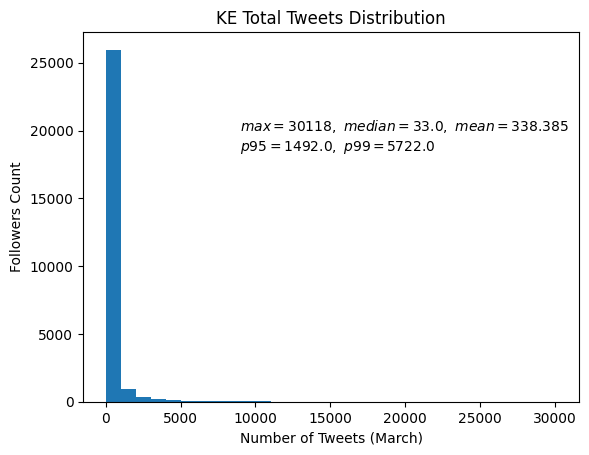

In [9]:
mu, max_n, mean, p_95, p_99 = (df_count['n_posts'].median(), 
                               df_count['n_posts'].max(), 
                               round(df_count['n_posts'].mean(), 3),
                              round(np.percentile(df_count['n_posts'], 95), 1),
                              round(np.percentile(df_count['n_posts'], 99), 1))
plt.hist(df_count['n_posts'], bins = 30)


plt.xlabel('Number of Tweets (March)')
plt.ylabel('Followers Count')
plt.title(f'{country} Total Tweets Distribution')
plt.text(9000, 20000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(9000, 18500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_total_tweets_{country}_batch2_march.png')
#plt.ylim(0, 1000)
plt.show()

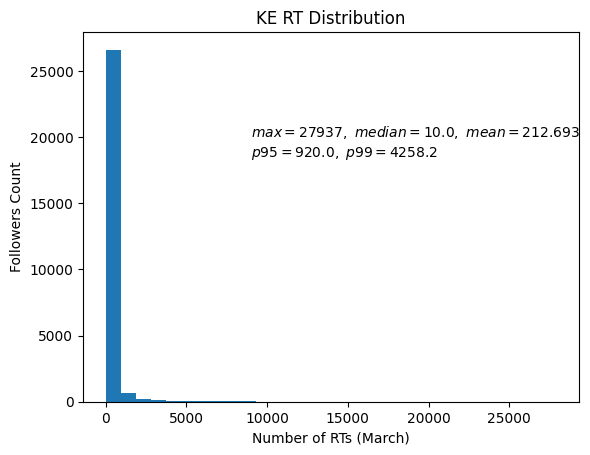

In [11]:
mu, max_n, mean,p_95, p_99 = (df_count['RT'].median(), df_count['RT'].max(), 
                   round(df_count['RT'].mean(), 3),
                   round(np.percentile(df_count['RT'], 95), 1),
                   round(np.percentile(df_count['RT'], 99), 1))
plt.hist(df_count['RT'], bins = 30)


plt.xlabel('Number of RTs (March)')
plt.ylabel('Followers Count')
plt.title(f'{country} RT Distribution')
plt.text(9000, 20000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(9000, 18500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_rt_{country}_batch2_march.png')
#plt.ylim(0, 1000)
plt.show()

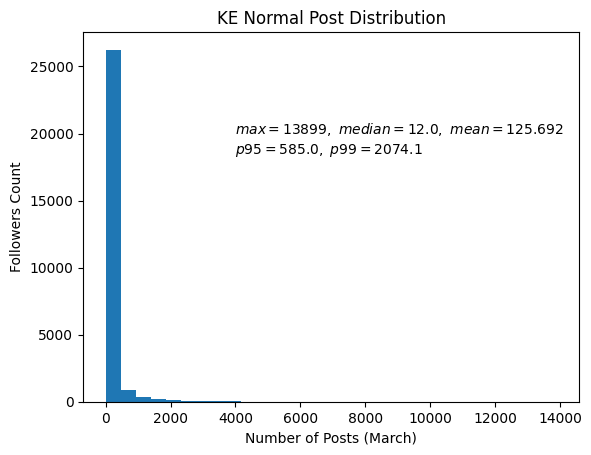

In [12]:
mu, max_n, mean, p_95, p_99 = (df_count['post'].median(), df_count['post'].max(), 
                   round(df_count['post'].mean(), 3),
                   round(np.percentile(df_count['post'], 95), 1),
                   round(np.percentile(df_count['post'], 99), 1))
plt.hist(df_count['post'], bins = 30)


plt.xlabel('Number of Posts (March)')
plt.ylabel('Followers Count')
plt.title(f'{country} Normal Post Distribution')
plt.text(4000, 20000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(4000, 18500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_normal_{country}_batch2_march.png')
#plt.ylim(0, 1000)
plt.show()

In [7]:
df_count = df_count[df_count['n_posts']<5000]
n_posts_ke_1 = df_count['n_posts'].sum()

In [9]:
df_count = second_month[['lang', 'author_id']].groupby(['author_id']).count()
df_count.rename({'lang': 'n_posts'}, axis=1, inplace=True)

df_agg = second_month[['author_id', 'RT', 'post']].groupby(['author_id']).sum().reset_index()

df_count = df_count.merge(df_agg, on = 'author_id', how='left')
df_count

,author_id,n_posts,RT,post
0,1000002795213385734,291,2,289
1,1000049830557822978,7,7,0
2,1000147246095257600,139,75,64
3,1000438150773297153,6,3,3
4,1000532778486849536,768,766,2
...,...,...,...,...
27448,999742211234455552,21,0,21
27449,999744221220392960,8,3,5
27450,999915904556134401,323,138,185
27451,999936965226135552,200,46,154


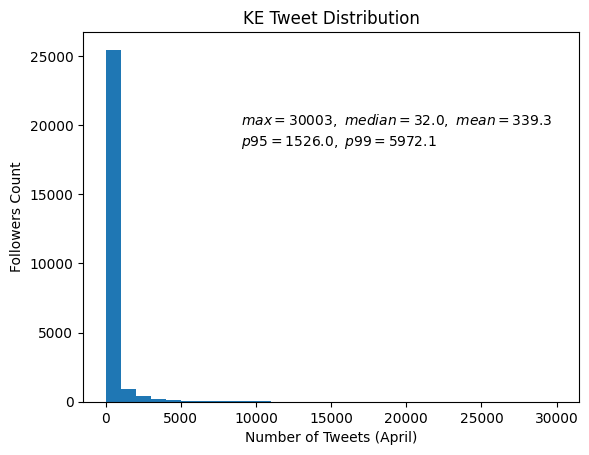

In [10]:
mu, max_n, mean, p_95, p_99 = (df_count['n_posts'].median(), 
                               df_count['n_posts'].max(), 
                               round(df_count['n_posts'].mean(), 3),
                              round(np.percentile(df_count['n_posts'], 95), 1),
                              round(np.percentile(df_count['n_posts'], 99), 1))
plt.hist(df_count['n_posts'], bins = 30)


plt.xlabel('Number of Tweets (April)')
plt.ylabel('Followers Count')
plt.title(f'{country} Tweet Distribution')
plt.text(9000, 20000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(9000, 18500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_total_tweets_{country}_batch2_april.png')
#plt.ylim(0, 1000)
plt.show()

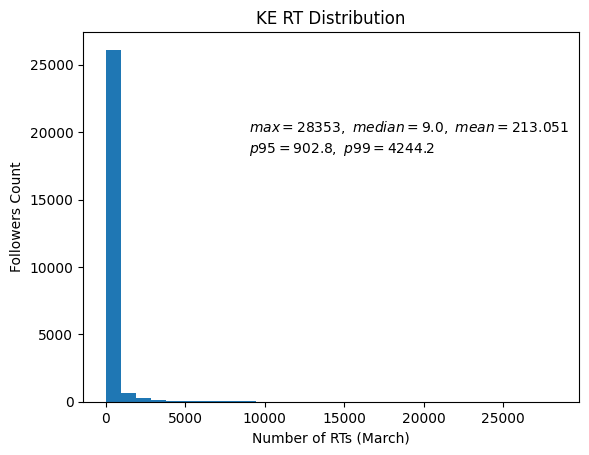

In [11]:
mu, max_n, mean,p_95, p_99 = (df_count['RT'].median(), df_count['RT'].max(), 
                   round(df_count['RT'].mean(), 3),
                   round(np.percentile(df_count['RT'], 95), 1),
                   round(np.percentile(df_count['RT'], 99), 1))
plt.hist(df_count['RT'], bins = 30)


plt.xlabel('Number of RTs (March)')
plt.ylabel('Followers Count')
plt.title(f'{country} RT Distribution')
plt.text(9000, 20000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(9000, 18500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_rt_{country}_batch2_april.png')
#plt.ylim(0, 1000)
plt.show()

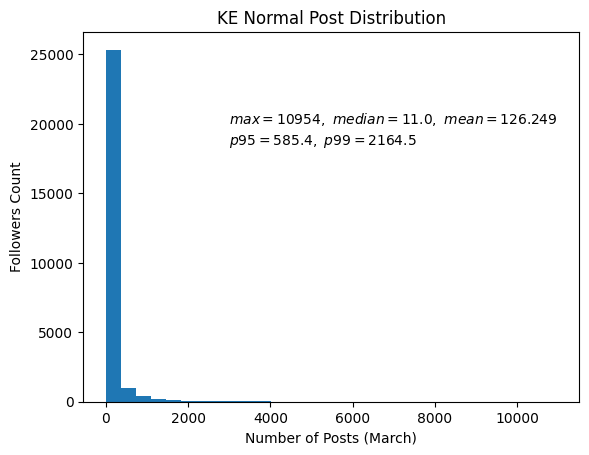

In [12]:
mu, max_n, mean, p_95, p_99 = (df_count['post'].median(), df_count['post'].max(), 
                   round(df_count['post'].mean(), 3),
                   round(np.percentile(df_count['post'], 95), 1),
                   round(np.percentile(df_count['post'], 99), 1))
plt.hist(df_count['post'], bins = 30)


plt.xlabel('Number of Posts (March)')
plt.ylabel('Followers Count')
plt.title(f'{country} Normal Post Distribution')
plt.text(3000, 20000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(3000, 18500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_normal_{country}_batch2_april.png')
#plt.ylim(0, 1000)
plt.show()

In [30]:
df_post_final = df_count[df_count['post']>round(np.percentile(df_count['post'], 95), 1)]
df_post_final = df_post_final[['author_id']]
df_post_final['dummy_post'] = 1
df_rt_final = df_count[df_count['RT']>round(np.percentile(df_count['RT'], 95), 1)]
df_rt_final = df_rt_final[['author_id']]
df_rt_final['dummy_rt'] = 1

df_merge_rt = df_rt_final.merge(df_post_final, on = 'author_id', how = 'left')
df_merge_rt['dummy_post'] = np.where(df_merge_rt['dummy_post'].isnull(), 0, 1)
df_merge_rt

,author_id,dummy_rt,dummy_post
0,1004797460370411526,1,1
1,1004816727157432320,1,0
2,1007404993132056583,1,1
3,1009041060914499584,1,0
4,1011033494460555264,1,1
...,...,...,...
1368,990132435949060096,1,0
1369,991637869130407936,1,0
1370,995168454096416768,1,1
1371,996842100674134017,1,0


In [31]:
df_merge_post = df_post_final.merge(df_rt_final, on = 'author_id', how = 'left')
df_merge_post['dummy_rt'] = np.where(df_merge_post['dummy_rt'].isnull(), 0, 1)
df_merge_post

,author_id,dummy_post,dummy_rt
0,1001336081047019520,1,0
1,1002488333468135424,1,0
2,1004797460370411526,1,1
3,1005356644803534848,1,0
4,100612482,1,0
...,...,...,...
1368,99260413,1,0
1369,995168454096416768,1,1
1370,996077114146275328,1,0
1371,997081000348930048,1,0


In [20]:
df_merge_rt['dummy_post'].mean()

0.4442825928623452

In [21]:
df_merge_post = df_post_final.merge(df_rt_final, on = 'author_id', how = 'left')
df_merge_post['dummy_rt'] = np.where(df_merge_post['dummy_rt'].isnull(), 0, 1)
df_merge_post['dummy_rt'].mean()

0.4442825928623452

In [22]:
df_merge_post

,author_id,dummy_post,dummy_rt
0,1001336081047019520,1,0
1,1002488333468135424,1,0
2,1004797460370411526,1,1
3,1005356644803534848,1,0
4,100612482,1,0
...,...,...,...
1368,99260413,1,0
1369,995168454096416768,1,1
1370,996077114146275328,1,0
1371,997081000348930048,1,0


In [29]:
df_posts_bots = df_count[df_count['n_posts']>round(np.percentile(df_count['n_posts'], 95), 1)]
df_posts_bots

,author_id,n_posts,RT,post
32,1002488333468135424,1756,478,1278
64,1004797460370411526,2328,1411,917
65,1004816727157432320,1743,1591,152
87,1007404993132056583,3755,1437,2318
135,1011033494460555264,10424,2223,8201
...,...,...,...,...
27309,988456691162329090,2336,591,1745
27353,991285849311645696,1758,374,1384
27389,995168454096416768,3814,2194,1620
27410,996842100674134017,1861,1729,132


In [32]:
country = 'SA'
path_tw, base, rand, baseline, agg, agg_base = get_path(country, 'march')

df_final = pd.DataFrame()
for i in tqdm(range(0, 10)):
    df = pd.read_parquet(f'{agg_base}predicted/baseline_batch2_{i}.parquet.gzip')
    df_final = pd.concat([df_final, df])

df_final = df_final.reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


In [33]:
df_final['RT'] = np.where((df_final['text'].str.contains('RT @', case=True, regex=False)) & 
                 (df_final['total_comments'] == 0), 1, 0)

df_final['post'] = np.where((~df_final['text'].str.contains('RT @', 
                    case=True, regex=False)) | 
                    (df_final['total_comments'] > 0), 1, 0)

In [34]:
df_count = df_final[['lang', 'author_id']].groupby(['author_id']).count()
df_count.rename({'lang': 'n_posts'}, axis=1, inplace=True)

df_agg = df_final[['author_id', 'RT', 'post']].groupby(['author_id']).sum().reset_index()

df_count = df_count.merge(df_agg, on = 'author_id', how='left')
df_count

,author_id,n_posts,RT,post
0,1000012400664481793,1,0,1
1,1000020055973945344,217,179,38
2,1000040250448732160,2,2,0
3,1000076246804463616,422,286,136
4,1000234790254194693,296,164,132
...,...,...,...,...
19552,999698155397697537,18,16,2
19553,999781765681176576,22,1,21
19554,999967548987846656,371,31,340
19555,999969404560474113,1,1,0


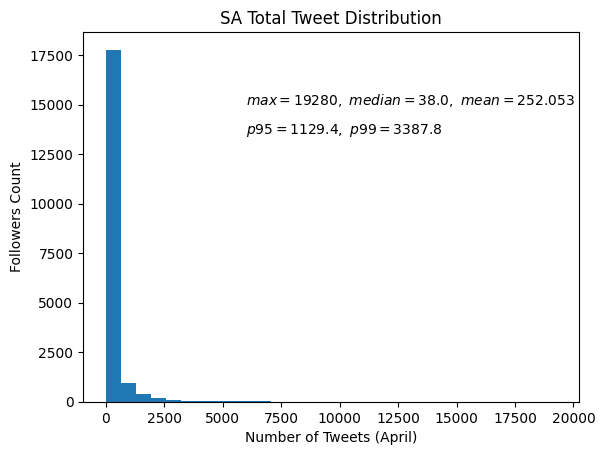

In [20]:
mu, max_n, mean, p_95, p_99 = (df_count['n_posts'].median(), 
                               df_count['n_posts'].max(), 
                               round(df_count['n_posts'].mean(), 3),
                              round(np.percentile(df_count['n_posts'], 95), 1),
                              round(np.percentile(df_count['n_posts'], 99), 1))
plt.hist(df_count['n_posts'], bins = 30)


plt.xlabel('Number of Tweets (April)')
plt.ylabel('Followers Count')
plt.title(f'{country} Total Tweet Distribution')
plt.text(6000, 15000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(6000, 13500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_total_tweets_{country}_batch2_april.png')
#plt.ylim(0, 1000)
plt.show()

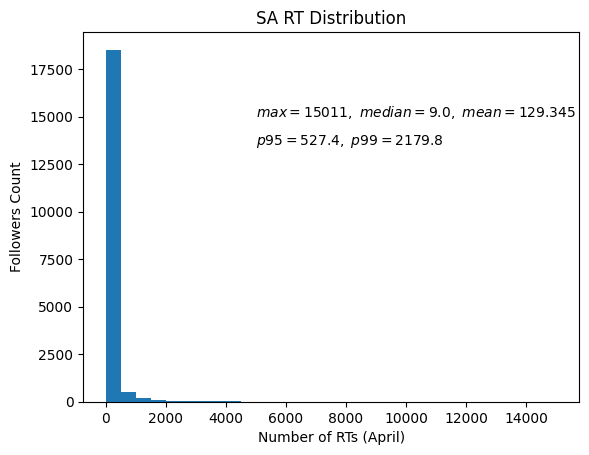

In [21]:
mu, max_n, mean,p_95, p_99 = (df_count['RT'].median(), df_count['RT'].max(), 
                   round(df_count['RT'].mean(), 3),
                   round(np.percentile(df_count['RT'], 95), 1),
                   round(np.percentile(df_count['RT'], 99), 1))
plt.hist(df_count['RT'], bins = 30)


plt.xlabel('Number of RTs (April)')
plt.ylabel('Followers Count')
plt.title(f'{country} RT Distribution')
plt.text(5000, 15000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(5000, 13500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_rt_{country}_batch2_april.png')
#plt.ylim(0, 1000)
plt.show()

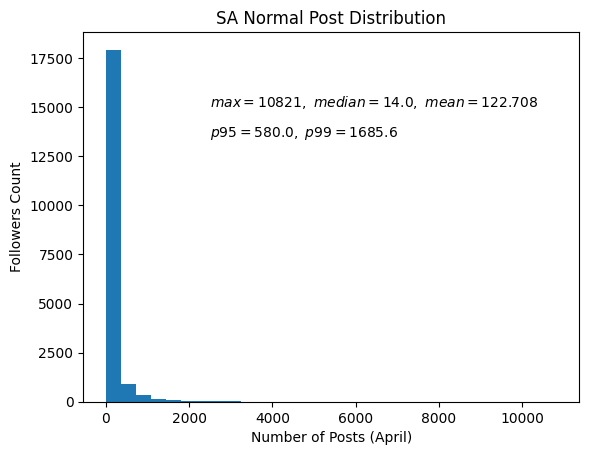

In [22]:
mu, max_n, mean, p_95, p_99 = (df_count['post'].median(), df_count['post'].max(), 
                   round(df_count['post'].mean(), 3),
                   round(np.percentile(df_count['post'], 95), 1),
                   round(np.percentile(df_count['post'], 99), 1))
plt.hist(df_count['post'], bins = 30)


plt.xlabel('Number of Posts (April)')
plt.ylabel('Followers Count')
plt.title(f'{country} Normal Post Distribution')
plt.text(2500, 15000, f'$max={max_n},\ median={mu},\ mean={mean}$')
plt.text(2500, 13500, f'$p95={p_95},\ p99={p_99}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/dist_normal_{country}_batch2_april.png')
#plt.ylim(0, 1000)
plt.show()

In [35]:
df_total_final = df_count[df_count['n_posts']<round(np.percentile(df_count['n_posts'], 95), 1)]
df_total_final['n_posts'].sum()

2274564

In [44]:
round(np.percentile(df_count['n_posts'], 95))

1129

In [36]:
df_total_final['n_posts'].sum()*2

4549128

In [ ]:
# RT Analysis:

In [37]:
df_post_final = df_count[df_count['post']>round(np.percentile(df_count['post'], 95), 1)]
df_post_final = df_post_final[['author_id']]
df_post_final['dummy_post'] = 1
df_rt_final = df_count[df_count['RT']>round(np.percentile(df_count['RT'], 95), 1)]
df_rt_final = df_rt_final[['author_id']]
df_rt_final['dummy_rt'] = 1

df_merge_rt = df_rt_final.merge(df_post_final, on = 'author_id', how = 'left')
df_merge_rt['dummy_post'] = np.where(df_merge_rt['dummy_post'].isnull(), 0, 1)
df_merge_rt

,author_id,dummy_rt,dummy_post
0,1000521896125976577,1,1
1,1000898384151154688,1,0
2,1002633393627193346,1,0
3,1003554141757636608,1,0
4,1003697563,1,0
...,...,...,...
973,997725925864366080,1,0
974,997971961400758272,1,0
975,998536275551576064,1,1
976,999039638953234432,1,1


In [39]:
df_merge_rt['dummy_post'].mean()

0.3057259713701431

In [40]:
df_merge_post = df_post_final.merge(df_rt_final, on = 'author_id', how = 'left')
df_merge_post['dummy_rt'] = np.where(df_merge_post['dummy_rt'].isnull(), 0, 1)
df_merge_post['dummy_rt'].mean()

0.3060388945752303

In [41]:
df_full_merge = df_post_final.merge(df_rt_final, on = 'author_id', 
                                    how = 'outer')

In [42]:
df_full_merge

,author_id,dummy_post,dummy_rt
0,1000521896125976577,1.0,1.0
1,1002115910210129921,1.0,NaN
2,1002163055478927361,1.0,NaN
3,1002622962384670726,1.0,NaN
4,1004826723828011009,1.0,1.0
...,...,...,...
1651,994706238754738176,NaN,1.0
1652,997206484453871616,NaN,1.0
1653,997725925864366080,NaN,1.0
1654,997971961400758272,NaN,1.0
